Inrix data exploration

* truck types (VehicleWeightClass) - need to work with ProviderDetails.csv
* O-D
* Time of day

In [86]:
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pyodbc
import pymssql
import sqlalchemy
from shapely import wkt
import ogr

import json
from bokeh.io import show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.tile_providers import get_provider, Vendors
from bokeh.plotting import figure, output_file, show

In [2]:
#load the data
data_path = r'X:\Trans\Freight\Data\INRIXSample\TripBulkReport-tripBulk_20200813170926316_trip_paths_freight_usa_wa_everett_20150513'

#trajectories data
trajectories_header = pd.read_csv(os.path.join(data_path, 'schema', 'TripBulkReportTrajectoriesHeaders.csv'))
traj_df = pd.read_csv(os.path.join(data_path, 'data', 'trajs.csv'), names = trajectories_header.columns)

C:\Users\pbutrina\AppData\Local\Continuum\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
#trips data
trips_header = pd.read_csv(os.path.join(data_path, 'schema', 'TripBulkReportTripsHeaders.csv'))
trips_df = pd.read_csv(os.path.join(data_path, 'data', 'trips.csv'), names = trips_header.columns)

In [24]:
#vehicle data
vehicle_header = pd.read_csv(os.path.join(data_path, 'schema', 'TripBulkReportProviderDetailsHeaders.csv'))
vehicle_df = pd.read_csv(os.path.join(data_path, 'schema', 'TripBulkReportProviderDetails.csv'), names = vehicle_header.columns)

In [25]:
def read_from_sde(connection_string, feature_class_name,
                  crs={'init': 'epsg:2285'}):
    """
    Returns the specified feature class as a geodataframe from ElmerGeo.
    
    Parameters
    ----------
    connection_string : SQL connection string that is read by geopandas 
                        read_sql function
    
    feature_class_name: the name of the featureclass in PSRC's ElmerGeo 
                        Geodatabase
    
    cs: cordinate system
    """

    engine = sqlalchemy.create_engine(connection_string)
    con=engine.raw_connection()
    feature_class_name = feature_class_name + '_evw'
    df=pd.read_sql('select *, Shape.STAsText() as geometry from %s' % 
                   (feature_class_name), con=con)
    con.close()
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf=gpd.GeoDataFrame(df, geometry='geometry')
    gdf.crs = crs
    cols = [col for col in gdf.columns if col not in 
            ['Shape', 'GDB_GEOMATTR_DATA', 'SDE_STATE_ID']]
    
    return gdf[cols]

In [26]:
gdb_connection_string = 'mssql+pyodbc://AWS-PROD-SQL\Sockeye/OSMTest?driver=SQL Server?Trusted_Connection=yes'
name = 'ElmerGeo.DBO.tract2010'

In [27]:
tracts = read_from_sde(gdb_connection_string,name )

C:\Users\pbutrina\AppData\Local\Continuum\anaconda3\envs\myenv\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

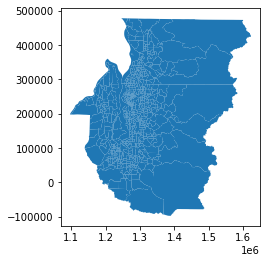

In [28]:
tracts.plot()

In [29]:
pd.set_option('display.max_columns', None)
trips_df.head(10)


,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,EndLocLat,EndLocLon,GeospatialType,ProviderType,ProviderDrivingProfile,VehicleWeightClass,ProbeSourceType,OriginZoneName,DestinationZoneName,EndpointType,TripMeanSpeedKph,TripMaxSpeedKph,TripDistanceMeters,MovementType,OriginCbg,DestCbg,StartTimezone,EndTimezone,WaypointFreqSec,StartQk,EndQk
0,078a0d3bc51bc9e533532cd25b75514c,68110726fea7b51fe1f4226264a04953,54229abfcfa5649e7003b83dd4755294,1,2015-05-13T20:21:34.000Z,3,2015-05-13T21:05:15.000Z,3,47.97015,-122.19749,47.69820,-122.18513,EE,2,3,2,1,NaN,NaN,NaN,49.528603,102.321811,36059.574817,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,63.926829,21230030001121212,21230030201332211
1,4cdd98f6444eaf562ab5116eb0f4a588,b2398bbe366c8dc0563ab0f31688c0c2,1534b76d325a8f591b52d302e7181331,1,2015-05-13T22:30:17.000Z,3,2015-05-14T00:19:52.000Z,3,47.63994,-122.40211,48.00416,-122.06703,EE,2,3,2,1,NaN,NaN,NaN,30.361626,94.589136,55452.137076,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,134.183673,21230021313232123,21230012233221001
2,7e9f82bd802f2294285a539061fdaacc,fa7378c980efdc8b252f835db69123be,26657d5ff9020d2abefe558796b99584,1,2015-05-13T14:39:37.000Z,3,2015-05-13T16:36:40.000Z,3,48.09046,-122.18513,47.23775,-122.24418,EE,2,3,2,1,NaN,NaN,NaN,52.353350,94.240729,102132.660501,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,270.115385,21230012221130031,21230032201203200
3,967f3fa239897875e5e7fdfc52df3a80,b8c416dff599605491aa44412bcc56e1,6cdd60ea0045eb7a6ec44c54d29ed402,1,2015-05-13T23:17:39.000Z,3,2015-05-14T01:14:27.000Z,3,48.33023,-122.16316,47.65937,-122.33482,EE,2,3,2,1,NaN,NaN,NaN,51.804359,115.924988,100845.818852,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,113.032258,21230012030002211,21230030202200330
4,e7a1e285c024e7e875352e87e336395a,ca1e6fe91e4ad4cf350870eb278734f8,45c48cce2e2d7fbdea1afc51c7c6ad26,1,2015-05-13T20:02:28.000Z,3,2015-05-13T20:35:40.000Z,3,47.89654,-122.25379,48.12897,-122.17689,EE,2,4,3,1,NaN,NaN,NaN,52.841851,116.692279,29239.157739,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,48.585366,21230030003200203,21230012203313001
5,098bff1d1f9937a84c38eec732e9c16a,323a033752002ae223ebe2db2f4e13f6,1534b76d325a8f591b52d302e7181331,1,2015-05-13T20:33:24.000Z,3,2015-05-13T20:59:16.000Z,3,47.73424,-122.29637,47.90943,-122.22358,EE,2,3,2,1,NaN,NaN,NaN,63.046620,93.751077,27180.098291,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,86.222222,21230030200120212,21230030003030333
6,e29ed0b3da331b509a49b4feba5d28a9,bbe5b5abedc716e4f9cea8c8876a022d,6cdd60ea0045eb7a6ec44c54d29ed402,1,2015-05-13T19:14:57.000Z,3,2015-05-13T21:06:56.000Z,3,47.92508,-122.25517,47.56309,-122.36366,IE,2,3,2,1,polygon_usa_wa_everett_psrc,NaN,NaN,33.329207,106.331100,62205.261238,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,117.877193,21230030003000220,21230021333112221
7,f169fc48f6f6e75010af83d3bc5b4fe4,43d50b1f3ca0e4964992825bb2451e98,45c48cce2e2d7fbdea1afc51c7c6ad26,1,2015-05-13T21:12:31.000Z,3,2015-05-13T21:19:13.000Z,3,47.92324,-122.22633,47.93796,-122.25379,II,2,4,3,1,polygon_usa_wa_everett_psrc,polygon_usa_wa_everett_psrc,NaN,24.012497,23.966638,2681.395506,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,201.000000,21230030003012101,21230030001222001
8,f709a7b874b4444ebab67d122fd7a623,526ecbcb78ba477d321bb334ec825fe8,a597e50502f5ff68e3e25b9114205d4a,1,2015-05-13T14:46:49.000Z,3,2015-05-13T15:08:28.000Z,3,47.97751,-122.18788,47.97751,-122.18788,EE,2,3,2,1,NaN,NaN,NaN,32.533991,93.304878,11739.348488,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,144.333333,21230030001112203,21230030001112203
9,3a94e7249af7582450b7fd4b35ab4828,7650460a2d2e468d109544681c5571a6,f033ab37c30201f73f142449d037028d,1,2015-05-13T22:06:46.000Z,3,2015-05-13T22:22:53.000Z,3,47.92508,-122.21672,47.88181,-122.23045,IE,2,3,2,1,polygon_usa_wa_everett_psrc,NaN,NaN,27.985473,86.255557,7517.209014,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,42.043478,21230030003011320,21230030003230212


In [13]:
# select 
vehicle_df.groupby('VehicleWeightClass').count()

,ProviderId,ProviderType,ProviderDrivingProfile,ProbeSourceType
VehicleWeightClass,,,,
Heavy Duty Trucks: > 26000 lb.,16,16,16,16
Light Duty Truck/Passenger Vehicle: Ranges from 0 to 14000 lb.,115,115,115,115
Medium Duty Trucks / Vans: ranges from 14001-26000 lb.,64,64,64,64


In [30]:
trips_df.shape

(3135, 31)

In [31]:
#join trips data and vehicle data

trips_vehicle = pd.merge(trips_df,vehicle_df, on='ProviderId')

In [33]:
pd.set_option('display.max_columns', None)
g_o_trips_vehicle.head()

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,EndLocLat,EndLocLon,GeospatialType,ProviderType_x,ProviderDrivingProfile_x,VehicleWeightClass_x,ProbeSourceType_x,OriginZoneName,DestinationZoneName,EndpointType,TripMeanSpeedKph,TripMaxSpeedKph,TripDistanceMeters,MovementType,OriginCbg,DestCbg,StartTimezone,EndTimezone,WaypointFreqSec,StartQk,EndQk,ProviderType_y,ProviderDrivingProfile_y,VehicleWeightClass_y,ProbeSourceType_y,geometry
0,078a0d3bc51bc9e533532cd25b75514c,68110726fea7b51fe1f4226264a04953,54229abfcfa5649e7003b83dd4755294,1,2015-05-13T20:21:34.000Z,3,2015-05-13T21:05:15.000Z,3,47.97015,-122.19749,47.69820,-122.18513,EE,2,3,2,1,NaN,NaN,NaN,49.528603,102.321811,36059.574817,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,63.926829,21230030001121212,21230030201332211,fleet,Field Service / Local Delivery Fleets,Medium Duty Trucks / Vans: ranges from 14001-2...,EmbeddedGPS,POINT (-122.18513 47.69820)
1,17f366d8cca6563c1b7cadb291701314,e62ae3e2f7b9b848a6804b7b82ca853b,54229abfcfa5649e7003b83dd4755294,1,2015-05-13T15:13:36.000Z,3,2015-05-13T15:26:12.000Z,3,47.90391,-122.20573,47.99497,-122.19200,EE,2,3,2,1,NaN,NaN,NaN,53.776768,97.920450,11293.121302,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,68.727273,21230030003122302,21230012223323130,fleet,Field Service / Local Delivery Fleets,Medium Duty Trucks / Vans: ranges from 14001-2...,EmbeddedGPS,POINT (-122.19200 47.99497)
2,8e5d6399a3079f84f6cc4420f90f1a36,6446629a6063095fa9e6f235678facc2,54229abfcfa5649e7003b83dd4755294,1,2015-05-13T05:56:51.000Z,2,2015-05-13T06:44:56.000Z,2,47.69913,-122.18513,47.93612,-122.20024,EI,2,3,2,1,NaN,polygon_usa_wa_everett_psrc,NaN,47.557702,102.516653,38112.214003,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,73.974359,21230030201332033,21230030001323020,fleet,Field Service / Local Delivery Fleets,Medium Duty Trucks / Vans: ranges from 14001-2...,EmbeddedGPS,POINT (-122.20024 47.93612)
3,0aa3e15826085e63bd13fe685a8ac69d,0845fcf7c3c3480d7ac144570e8c60f9,54229abfcfa5649e7003b83dd4755294,1,2015-05-13T03:45:33.000Z,2,2015-05-13T06:11:04.000Z,2,48.11339,-122.14393,47.16124,-120.84892,EE,2,3,2,1,NaN,NaN,NaN,78.397697,102.159220,190136.191991,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,91.905263,21230012212232003,21230122203222220,fleet,Field Service / Local Delivery Fleets,Medium Duty Trucks / Vans: ranges from 14001-2...,EmbeddedGPS,POINT (-120.84892 47.16124)
4,95f583663242d5085857c93ce3e9dac1,635cf27092070c0665ca76fe8a0edad2,54229abfcfa5649e7003b83dd4755294,1,2015-05-13T22:01:30.000Z,3,2015-05-13T22:46:05.000Z,3,47.81269,-122.23594,47.93704,-122.30735,EE,2,3,2,1,NaN,NaN,NaN,32.759410,100.210403,24342.061795,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,83.593750,21230030023001110,21230030000233012,fleet,Field Service / Local Delivery Fleets,Medium Duty Trucks / Vans: ranges from 14001-2...,EmbeddedGPS,POINT (-122.30735 47.93704)


In [32]:
g_o_trips_vehicle = gpd.GeoDataFrame(
    trips_vehicle, geometry=gpd.points_from_xy(trips_vehicle.EndLocLon, trips_vehicle.EndLocLat))
g_o_trips_vehicle.crs = "EPSG:4326"

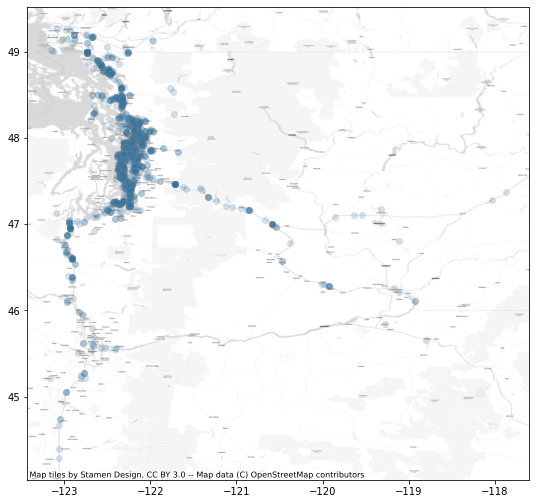

In [34]:
points_ax = g_o_trips_vehicle.plot(figsize=(9, 16), zorder=15, ec='gray', alpha=0.2)
ctx.add_basemap(points_ax, source=ctx.providers.Stamen.TonerLite,zoom=10,crs='EPSG:4326')


In [35]:
g_o_trips_vehicle.plot

<bound method GeoDataFrame.plot of                                 TripId                          DeviceId  \
0     078a0d3bc51bc9e533532cd25b75514c  68110726fea7b51fe1f4226264a04953   
1     17f366d8cca6563c1b7cadb291701314  e62ae3e2f7b9b848a6804b7b82ca853b   
2     8e5d6399a3079f84f6cc4420f90f1a36  6446629a6063095fa9e6f235678facc2   
3     0aa3e15826085e63bd13fe685a8ac69d  0845fcf7c3c3480d7ac144570e8c60f9   
4     95f583663242d5085857c93ce3e9dac1  635cf27092070c0665ca76fe8a0edad2   
...                                ...                               ...   
3130  b733cb70720dd71352ad85c013495eff  3416f291ee8aa6832a473187238acc64   
3131  930d9f15b57b8c32ee4c5358d791d85c  48d7a2894d4cf0fceadacc09f67ca6c4   
3132  0830202f72a25527f35a896da5d2894d  9cfac4847434570f803334adfdaf97a1   
3133  1a1d2603e838ff76cf10b1983b4fc454  48d7a2894d4cf0fceadacc09f67ca6c4   
3134  2d911d9e7267373bcb801ce267e69ad1  9cfac4847434570f803334adfdaf97a1   

                            ProviderId  Mode        

In [36]:
tracts = tracts.to_crs(epsg=4326)
g_o_trips_vehicle = g_o_trips_vehicle.to_crs(epsg=4326)

<AxesSubplot:>

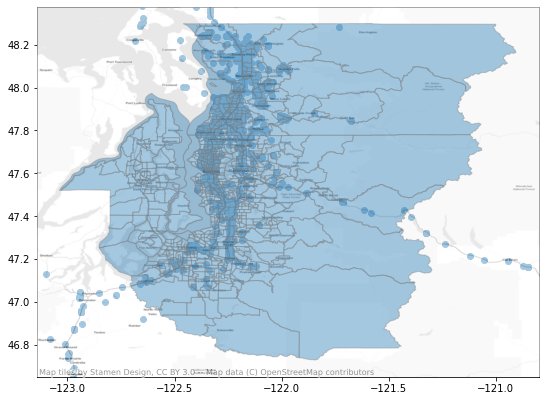

In [96]:
#tracts.crs = "EPSG:32633"
tracts_plot = tracts.plot(figsize=(9, 16), zorder=10, ec='gray', alpha=0.4)
#ctx.add_basemap(tracts_plot, source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(tracts_plot, source=ctx.providers.Stamen.TonerLite, zoom=10, alpha=0.6, zorder=8 , crs='EPSG:4326' )
g_o_trips_vehicle.plot(ax = tracts_plot)


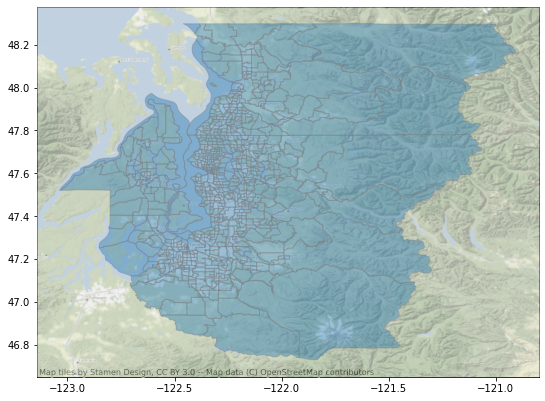

In [12]:
tracts = tracts.to_crs(epsg=4326)

tracts_plot = tracts.plot(figsize=(9, 16), zorder=10, ec='gray', alpha=0.4)
ctx.add_basemap(tracts_plot, source=ctx.providers.Stamen.Terrain, zoom=10, alpha=0.6, zorder=8 , crs='EPSG:4326' )
#ctx.add_basemap(tracts_plot, crs='EPSG:4326', zoom = 18)


In [104]:
tracts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [103]:
g_o_trips_vehicle.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
#spatial join - tract and trips

In [37]:
tract_trips = gpd.sjoin(tracts, g_o_trips_vehicle, how='inner', op='intersects')

In [119]:
tract_trips.dtypes

OBJECTID                       int64
statefp10                     object
countyfp10                    object
tractce10                     object
geoid10                       object
name10                        object
namelsad10                    object
mtfcc10                       object
funcstat10                    object
aland10                      float64
awater10                     float64
intptlat10                    object
intptlon10                    object
name_val                     float64
geometry                    geometry
index_right                    int64
TripId                        object
DeviceId                      object
ProviderId                    object
Mode                           int64
StartDate                     object
StartWDay                      int64
EndDate                       object
EndWDay                        int64
StartLocLat                  float64
StartLocLon                  float64
EndLocLat                    float64
E

In [44]:
pd.set_option('display.max_columns', None)
tract_trips.shape

(2646, 51)

In [54]:
destinations_by_tract=tract_trips.groupby('namelsad10')['namelsad10'].count()

destinations_by_tract_count=destinations_by_tract.reset_index(name='count')

In [56]:
destinations_by_tract_count.head()

,namelsad10,count
0,Census Tract 1,4
1,Census Tract 100.01,4
2,Census Tract 102,1
3,Census Tract 104.02,1
4,Census Tract 105,2


In [57]:
destinations_by_tract_count = pd.merge(destinations_by_tract_count, tracts,on=["namelsad10"])

In [190]:
type(destinations_by_tract_count)
destinations_by_tract_count.dtypes

namelsad10      object
count            int64
OBJECTID         int64
statefp10       object
countyfp10      object
tractce10       object
geoid10         object
name10          object
mtfcc10         object
funcstat10      object
aland10        float64
awater10       float64
intptlat10      object
intptlon10      object
name_val       float64
geometry      geometry
dtype: object

In [58]:
destinations_by_tract_count = gpd.GeoDataFrame(destinations_by_tract_count, crs="EPSG:4326", geometry='geometry')


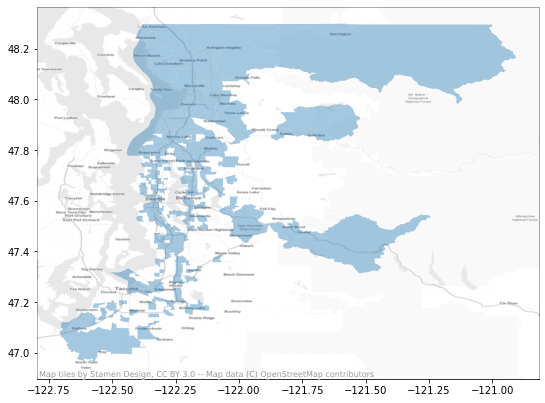

In [182]:
tracts_plot = destinations_by_tract_count.plot(figsize=(9, 16), zorder=10, alpha=0.4)
#ctx.add_basemap(tracts_plot, source=ctx.providers.Stamen.TonerLite)
ctx.add_basemap(tracts_plot, source=ctx.providers.Stamen.TonerLite, zoom=10, alpha=0.6, zorder=8 , crs='EPSG:4326' )

In [100]:
geosource = GeoJSONDataSource(geojson = destinations_by_tract_count.to_crs(3857).to_json())

In [101]:
output_file("tile.html")
# Define color palettes
tile_provider = get_provider(Vendors.OSM)
palette = brewer['BuGn'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 350)
# Define custom tick labels for color bar.
tick_labels = {'0': '0', '50': '50',
 '100':'100', '150':'150',
 '200':'200', '250':'250',
 '300':'300', '350':'300+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p = figure(title = 'Truck Origins Grouped by Census Tract, May 2019', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,
                   fill_color = {'field':'count',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)
# Create hover tool
p.add_tools(HoverTool(renderers = [states],
                     tooltips = [('Tract','@tractce10'),
                               ('count', '@count')]))
# Specify layout
p.add_layout(color_bar, 'below')
p.add_tile(tile_provider)
show(p)

In [102]:
?p.add_tile

In [98]:
tile_provider

WMTSTileSource(id='2460', ...)

In [43]:
trips_summary = pd.DataFrame(traj_df['SegmentId'].value_counts())
trips_summary.reset_index(inplace = True)
trips_summary = trips_summary.rename(columns={"SegmentId": "trips", "index": "SegmentId"})


In [44]:
i_trips = trips_summary[~trips_summary['SegmentId'].str.contains('-')]
i_trips = i_trips.rename(columns={"trips" : "trips_i"})



In [45]:
j_trips = trips_summary[trips_summary['SegmentId'].str.contains('-')]
j_trips['SegmentId'] = j_trips['SegmentId'].str[1:]
j_trips = j_trips.rename(columns={"trips" : "trips_j"})

C:\Users\pbutrina\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
trips_summary

,SegmentId,trips
0,25794567_1,984
1,25794567_0,982
2,35134231_0,980
3,623704138_0,980
4,623704131_0,980
...,...,...
85876,-6142261_42,1
85877,6141851_7,1
85878,6126544_8,1
85879,376779005_0,1
